In [2]:
#importing libraries
import cv2
import os
import matplotlib.pyplot as plt

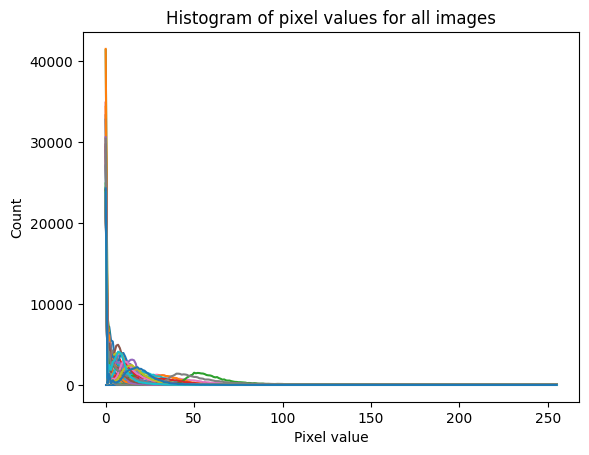

In [7]:
# Plotting pixel values of all images
dir_path = "test_images"
for filename in os.listdir(dir_path):
    img = cv2.imread(os.path.join(dir_path, filename))
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    plt.xlabel('Pixel value')
    plt.ylabel('Count')
    plt.title('Histogram of pixel values for all images')
    plt.plot(hist)
plt.show()

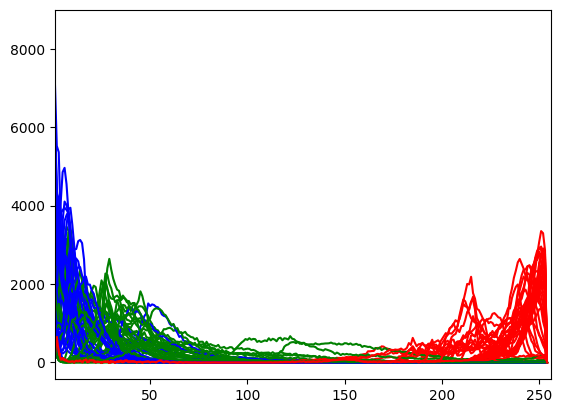

In [12]:
color = ('b','g','r')
for filename in os.listdir(dir_path):
    img = cv2.imread(os.path.join(dir_path, filename))
    if img is not None:  # Add this check
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[255],[1,255])
            plt.plot(histr,color = col)
            plt.xlim([1,256])
        
plt.show()


In [33]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('test_images/im01-RET029OD.jpg', cv2.IMREAD_COLOR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Find circles using Hough transform
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                           param1=50, param2=30, minRadius=0, maxRadius=0)

# Get the first circle (assuming only one circle)


# Get the center and radius of the circle

x = int(circles[0][0][0])
y = int(circles[0][0][1])
r = int(circles[0][0][2])
center= (x, y)
radius= r

# Draw the circle on the image
cv2.circle(img,  (x, y), r, (0, 255, 0), 2)

# Calculate the transformation matrix to correct the warping
dest_points = np.float32([[0, 0], [0, radius*2], [radius*2, 0], [radius*2, radius*2]])
src_points = np.float32([[center[0]-radius, center[1]-radius], [center[0]-radius, center[1]+radius], 
                         [center[0]+radius, center[1]-radius], [center[0]+radius, center[1]+radius]])

M = cv2.getPerspectiveTransform(src_points, dest_points)

# Apply the transformation to the image
result = cv2.warpPerspective(img, M, (radius*2, radius*2))

# Show the result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [14]:
####This bit actually works to tell me where the circle is
# Load the image
im01= cv2.imread('test_images/im01-RET029OD.jpg', cv2.IMREAD_COLOR)
# Convert the image to grayscale
gray = cv2.cvtColor(im01, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary image
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

# Detect circles using the Hough transform
circles = cv2.HoughCircles(thresh, cv2.HOUGH_GRADIENT, 1, minDist=50,
                           param1=200, param2=20, minRadius=0, maxRadius=0)

# Extract the coordinates and radius of the circle
x = int(circles[0][0][0])
y = int(circles[0][0][1])
r = int(circles[0][0][2])

# Draw a circle around the detected circle
cv2.circle(im01, (x, y), r, (0, 255, 0), 2)

# Display the image
cv2.imshow('image', im01)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Print the center coordinates and radius of the circle
print('Circle center:', (x, y))
print('Circle radius:', r)


Circle center: (187, 211)
Circle radius: 19


In [29]:
import numpy as np
import cv2

# Load the image
im01 = cv2.imread('test_images/im01-RET029OD.jpg', cv2.IMREAD_COLOR)

# Find the center coordinates and radius of the black circle
x0 = 187
y0 = 211
r = 19

# Create a mask for the black circle
mask = np.zeros((im01.shape[0], im01.shape[1]), dtype=np.uint8)
cv2.circle(mask, (x0, y0), r, 255, -1)

# Inpaint the black circle
output = cv2.inpaint(im01, mask, 3, cv2.INPAINT_NS)

cv2.imshow('image', output)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [25]:
# Load the image
im01 = cv2.imread('test_images/im01-RET029OD.jpg', cv2.IMREAD_COLOR)

# Find the center coordinates and radius of the black circle
x0 = 187
y0 = 211
r = 19

# Add reflection padding to the image
border_size = r  # adjust as needed
border = cv2.copyMakeBorder(im01, border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT_101)

# Find the center coordinates and radius of the black circle in the padded image
x0_pad = x0 + border_size
y0_pad = y0 + border_size

# Create a mask for the black circle in the padded image
mask = np.zeros((border.shape[0], border.shape[1]), dtype=np.uint8)
cv2.circle(mask, (x0_pad, y0_pad), r, 255, -1)

# Inpaint the black circle using the "ns" method
output = cv2.inpaint(border, mask, 3, cv2.INPAINT_NS)

# Extract the inpainted region from the padded image
output = output[border_size:-border_size, border_size:-border_size]

# Show the output image
cv2.imshow('image', output)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [24]:
im01= cv2.imread('test_images/im01-RET029OD.jpg', cv2.IMREAD_COLOR)

# Find the center coordinates and radius of the black circle
x0 = 187
y0 = 211
r = 19

# Create a mask for the black circle
mask = np.zeros((im01.shape[0], im01.shape[1]), dtype=np.uint8)
cv2.circle(mask, (x0, y0), r, 255, -1)

# Inpaint the black circle
output = cv2.inpaint(im01, mask, 3, cv2.INPAINT_NS)

# Save the output image
cv2.imshow('image', output)
cv2.waitKey(0)
cv2.destroyAllWindows()

